In [1]:
import warnings
warnings.filterwarnings("ignore")

## Библиотеки

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from copy import deepcopy
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
from sklearn import tree
import itertools
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, load_wine, load_boston
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torchvision import datasets
import pyfpgrowth
from torchvision import transforms

# Домашнее задание

Рассматривается две выборки: [
Shill Bidding Dataset Data Set](https://archive.ics.uci.edu/ml/datasets/Shill+Bidding+Dataset) и [Speaker Accent Recognition Data Set
](https://archive.ics.uci.edu/ml/datasets/Speaker+Accent+Recognition). Для обоих выборок построить AdaBoost, GradientBoosting, RandomForest, Bagging. Сравнить качество на обоих выборках. Отличается ли результат? Почему?

## 1. Shill Bidding Dataset

**Количественный анализ**:
- Количество объектов в выборке: 6321
- Количество признаков: 11. Из них категориальных 2 (в том числе ID аукциона), остальные - вещественные;
- Тип задачи - бинарная классификация.

In [3]:
raw_data = pd.read_csv("data/Shill Bidding Dataset.csv", index_col='Record_ID')

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6321 entries, 1 to 15144
Data columns (total 12 columns):
Auction_ID                6321 non-null int64
Bidder_ID                 6321 non-null object
Bidder_Tendency           6321 non-null float64
Bidding_Ratio             6321 non-null float64
Successive_Outbidding     6321 non-null float64
Last_Bidding              6321 non-null float64
Auction_Bids              6321 non-null float64
Starting_Price_Average    6321 non-null float64
Early_Bidding             6321 non-null float64
Winning_Ratio             6321 non-null float64
Auction_Duration          6321 non-null int64
Class                     6321 non-null int64
dtypes: float64(8), int64(3), object(1)
memory usage: 642.0+ KB


In [44]:
raw_data.sample(5)

,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
Record_ID,,,,,,,,,,,,
8540,1127,i***m,0.034483,0.047619,0.0,0.196472,0.142857,0.993593,0.196472,0.000000,5,0
14141,1404,9***1,0.111111,0.200000,0.0,0.010212,0.000000,0.000000,0.010212,0.333333,7,0
10947,2186,l***i,0.037500,0.272727,0.0,0.984079,0.000000,0.993593,0.946731,0.954545,5,0
2355,2212,2***a,0.045455,0.025641,0.0,0.005685,0.538462,0.993528,0.005685,0.000000,7,0
6963,1432,n***o,0.121951,0.333333,0.0,0.813340,0.000000,0.000000,0.811597,1.000000,7,0


In [6]:
raw_data.Class.unique()

array([0, 1])

In [9]:
raw_data.Bidder_ID.unique().shape

(1054,)

<AxesSubplot:>

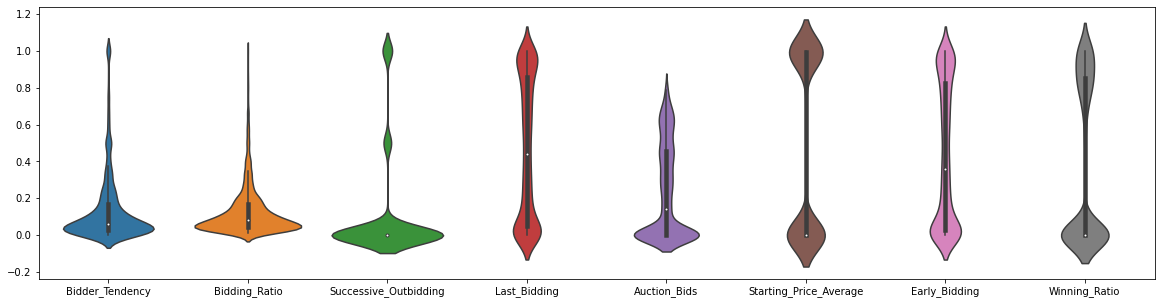

In [59]:
plt.figure(figsize=(20, 5))
sns.violinplot(data=raw_data.loc[:, ['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']])

<AxesSubplot:>

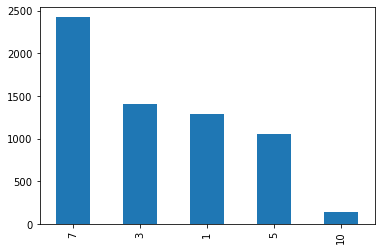

In [35]:
pd.value_counts(raw_data.Auction_Duration).plot(kind='bar')

In [29]:
# Pecrenatge of shill acutions:

print(f"% pos.ipynb_checkpoints/tive: {np.round(np.mean(raw_data.Class), 2)}")

% positive: 0.11


<AxesSubplot:>

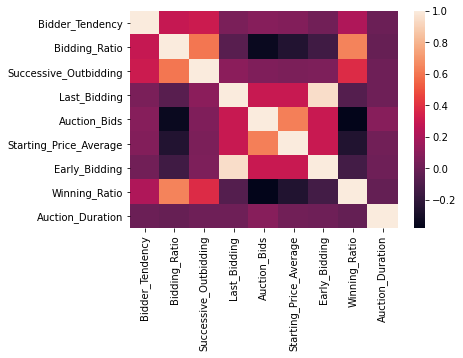

In [46]:
sns.heatmap(raw_data.drop(columns=['Class', 'Bidder_ID' , "Auction_ID"]).corr())

In [61]:
raw_data.Bidder_ID.unique().shape, raw_data.Auction_ID.unique().shape

((1054,), (807,))

**Качественный анализ:**

- Явная несбалансированность классов, примерно 9 нег:1 пол;
- Есть корреляции, однако не всегда они относятся к мошенникам: например, видно, что Early Bidding сильно коррелирует с Last_Bidding;
- В распределении почти всех признаков явно просматриваются отдельные группы объектов.

### Модели

Как уже было сказано, в выборке есть два категориальных признака: Bidder_ID и Auction_ID. Самый простой способ работы с ними - это применить one-hot encoding. Однако, количество уникальных значений для каждого из них порядка 1e3, что делает применение последнего метода затруднительным. Поэтому мы будем работать в предположении, что эти два признака нам не известны, а известны только параметры аукциона и статистика пользователя.

В качестве метрики качества будем использовать F1 Macro, в силу наличия несбалансированности в классах.

In [8]:
X = raw_data.drop(columns=['Bidder_ID', 'Auction_ID', 'Class'])
y = raw_data.Class

X_train, X_test, y_train, y_test = train_test_split(X, y)

X.shape, y.shape

((6321, 9), (6321,))

In [6]:
# target metric
from sklearn.metrics import f1_score, make_scorer
from functools import partial


target_metric = partial(f1_score, average='macro')
target_scorer = make_scorer(f1_score, average='macro')

#### 1.1 Ada Boost

In [4]:
# Ada boost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV

ada_param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=i) for i in [1, 3, 5, 7]],
    'n_estimators': [3, 10, 20]
}

In [98]:
cv = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=ada_param_grid, scoring=target_scorer)
cv.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                            DecisionTreeClassifier(max_depth=3),
                                            DecisionTreeClassifier(max_depth=5),
                                            DecisionTreeClassifier(max_depth=7)],
                         'n_estimators': [3, 10, 20]},
             scoring=make_scorer(f1_score, average=macro))

In [99]:
cv.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 20}

In [101]:
best_ada_1 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=20)
best_ada_1.fit(X_train, y_train)

y_pred = best_ada_1.predict(X_test)
print(classification_report(y_test, y_pred))
print('Target metric: ', target_metric(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1400
           1       0.98      0.97      0.97       181

    accuracy                           0.99      1581
   macro avg       0.99      0.98      0.99      1581
weighted avg       0.99      0.99      0.99      1581

Target metric:  0.9858597582971687


#### 1.2 Gradient Boosting

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gb_param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [10, 100, 200, 500]
}

cv = GridSearchCV(GradientBoostingClassifier(), param_grid=gb_param_grid, scoring=target_scorer)
cv.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [10, 100, 200, 500]},
             scoring=make_scorer(f1_score, average=macro))

In [12]:
cv.best_params_

{'learning_rate': 0.1, 'n_estimators': 200}

In [13]:
best_gb = GradientBoostingClassifier(**cv.best_params_)
best_gb.fit(X_train, y_train)

y_pred = best_gb.predict(X_test)
print(classification_report(y_test, y_pred))
print('Target metric: ', target_metric(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1417
           1       1.00      0.99      1.00       164

    accuracy                           1.00      1581
   macro avg       1.00      1.00      1.00      1581
weighted avg       1.00      1.00      1.00      1581

Target metric:  0.9982945811691989


#### 1.3 Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [7, 10, 15],
    'max_features': ['auto', 2, 5],
    'max_samples': [0.3, 0.5, 1]
    
}

cv = GridSearchCV(RandomForestClassifier(), param_grid=rf_param_grid, scoring=target_scorer)
cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 10, 15],
                         'max_features': ['auto', 2, 5],
                         'max_samples': [0.3, 0.5, 1],
                         'n_estimators': [10, 50, 100, 200, 500]},
             scoring=make_scorer(f1_score, average=macro))

In [17]:
cv.best_params_

{'max_depth': 15, 'max_features': 5, 'max_samples': 0.5, 'n_estimators': 10}

In [15]:
best_rf = RandomForestClassifier(**cv.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred))
print('Target metric: ', target_metric(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1417
           1       0.99      0.99      0.99       164

    accuracy                           1.00      1581
   macro avg       1.00      0.99      0.99      1581
weighted avg       1.00      1.00      1.00      1581

Target metric:  0.9948837435075968


#### 1.4 Bagging
Так так bagging является более общим подходом, то для определенности будем строить его над SVM с rbf ядрами.

In [22]:
from sklearn.ensemble import BaggingClassifier

bagging_params = {
    "base_estimator__C": [1e-2, 1, 10, 100],
    "n_estimators": [10, 50, 100],
    'max_features': [0.5, 1],
    'max_samples': [0.5, 1]
}

cv = GridSearchCV(BaggingClassifier(base_estimator=SVC()), param_grid=bagging_params, verbose=1, n_jobs=10)
cv.fit(X_train, y_train)
cv.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   11.9s
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:   34.7s finished


{'base_estimator__C': 10,
 'max_features': 0.5,
 'max_samples': 0.5,
 'n_estimators': 100}

In [29]:
best_bag = BaggingClassifier(base_estimator=SVC(C=cv.best_params_['base_estimator__C']),
                             n_estimators=cv.best_params_['n_estimators'],
                             max_features=cv.best_params_['max_features'],
                             max_samples=cv.best_params_['max_samples'])
best_bag.fit(X_train, y_train)

y_pred = best_bag.predict(X_test)

print(classification_report(y_test, y_pred))
print('Target metric: ', target_metric(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1417
           1       0.98      0.69      0.81       164

    accuracy                           0.97      1581
   macro avg       0.97      0.84      0.90      1581
weighted avg       0.97      0.97      0.96      1581

Target metric:  0.8958261070644005


#### Итоги по 1-й выборке:
1. В целом, все методы показали хорошее качество, что говорит о простоте выборки.
2. Методы с деревьями в качестве базовой модели классификации в показали себя лучше, чем SVM с rbf ядром, что коррелирует с выводом 3 о данных - в распределении многих признаков пристуствуют отдельные группы объектов, которые удобно описывать пороговыми правилами, из которых и состоят наши деревья. 
3. Методы с деревьями показали почти одинаковое качество, f1-macro в районе 99 - 98 процентов. Лучше всех формально себя показал GB, чуть хуже (< 0.5% разницы) RF, и на 3-м месте AdaBoost, который уступил примерно 1%.
4. Интересно, что у RF и Bagging оптимально число признаков в каждой ноде оказалось не sqrt(9) = 3, а 5.

## 2. Speaker Accent Recognition Data Set 

In [30]:
raw_data = pd.read_csv("data/accent-recognition-mfcc--1/accent-mfcc-data-1.csv")

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 13 columns):
language    329 non-null object
X1          329 non-null float64
X2          329 non-null float64
X3          329 non-null float64
X4          329 non-null float64
X5          329 non-null float64
X6          329 non-null float64
X7          329 non-null float64
X8          329 non-null float64
X9          329 non-null float64
X10         329 non-null float64
X11         329 non-null float64
X12         329 non-null float64
dtypes: float64(12), object(1)
memory usage: 33.5+ KB


In [31]:
raw_data.sample(5)

,language,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
292,US,11.793239,-8.060648,6.419787,10.369218,-6.002190,16.562828,-6.995932,3.753902,-0.605434,-6.807129,-0.803056,-7.734699
83,GE,-2.020461,1.111298,-2.107064,6.896539,-3.377759,10.684334,-10.489573,5.184497,-2.244897,-1.704590,3.565678,-2.529994
110,IT,-1.591825,3.147059,-1.316761,8.479270,-3.232697,11.212137,-9.015926,6.194512,-2.031739,-0.370499,5.243465,-3.953737
218,US,14.114726,-13.164407,3.753059,8.166042,-9.810916,10.545165,-10.555922,1.620419,1.627120,-5.083871,4.808198,-6.742841
99,IT,-1.270663,-0.781674,1.673638,7.571520,-8.549877,8.174395,-10.893478,5.119630,-0.324351,-3.813392,-0.611499,-0.560210


In [32]:
raw_data.language.unique()

array(['ES', 'FR', 'GE', 'IT', 'UK', 'US'], dtype=object)

**Количественный анализ:**

1. Число объектов - 329
2. Число признаков - 12, все вещественные
3. Число классов - 6
4. Тип задачи машинного обучения - мультиклассовая классификация.

Заранее отмечу, что в этой выборке значительно меньше объектов, чем в первой выборке, а признаков - больше.

<AxesSubplot:>

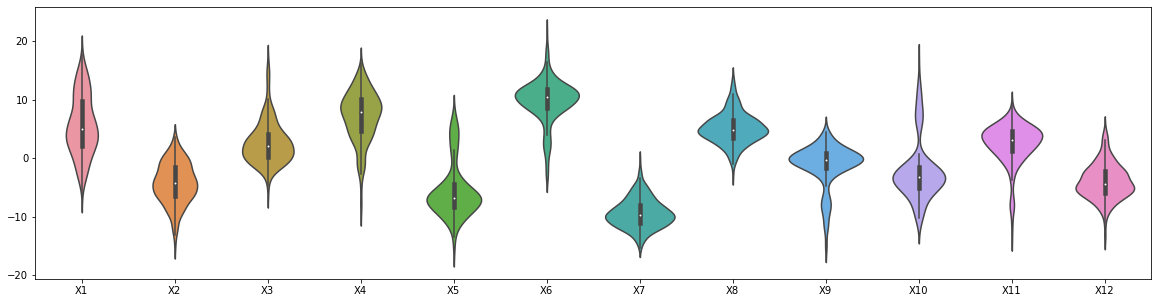

In [43]:
plt.figure(figsize=(20, 5))
sns.violinplot(data=raw_data.drop(columns='language'))

<AxesSubplot:>

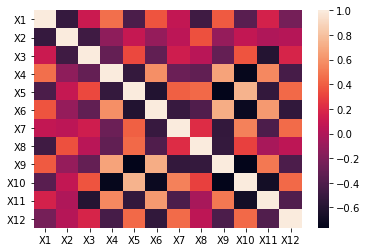

In [44]:
sns.heatmap(raw_data.drop(columns='language').corr())

<AxesSubplot:>

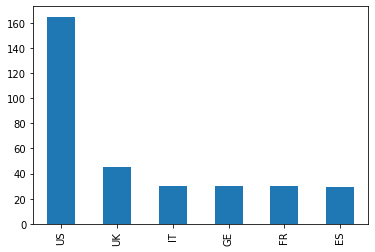

In [45]:
pd.value_counts(raw_data.language).plot(kind='bar')

**Качественный анализ**
1. Распределения имеют в основном четко выраженный пик, реже - 2.
2. Многие признаки имеют серьезные отрицательные корреляции между собой.
3. Опять же, присутсвтует несбалансированность классов (судя по всему, в пользу жителей США).

**Априорные предположения**
1. В силу небольшого размера и нетривиальности, кажется, что все алгоритмы покажут качество хуже, чем на 1-й выборке.
2. В силу опять же небольшого размера кажется, что bagging алгоритмы будут показывать себя лучше, чем boosting.

### Модели

In [47]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.drop(columns='language'), raw_data.language)

X_train.shape, X_test.shape

((246, 12), (83, 12))

#### 2.1 Ada Boost

In [74]:
# Ada boost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV

ada_param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=i) for i in [1, 3, 5, 7]],
    'learning_rate': [1e-2, 1e-1, 1, 10],
    'n_estimators': [3, 10, 20]
}

In [75]:
cv = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=ada_param_grid, scoring=target_scorer, n_jobs=10)
cv.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=10,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                            DecisionTreeClassifier(max_depth=3),
                                            DecisionTreeClassifier(max_depth=5),
                                            DecisionTreeClassifier(max_depth=7)],
                         'learning_rate': [0.01, 0.1, 1, 10],
                         'n_estimators': [3, 10, 20]},
             scoring=make_scorer(f1_score, average=macro))

In [76]:
cv.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=7),
 'learning_rate': 0.1,
 'n_estimators': 10}

In [77]:
best_ada_1 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=20)
best_ada_1.fit(X_train, y_train)

y_pred = best_ada_1.predict(X_test)
print(classification_report(y_test, y_pred))
print('Target metric: ', target_metric(y_test, y_pred))

              precision    recall  f1-score   support

          ES       1.00      0.78      0.88         9
          FR       0.40      0.29      0.33         7
          GE       0.00      0.00      0.00         8
          IT       0.67      0.22      0.33         9
          UK       0.55      0.40      0.46        15
          US       0.47      0.77      0.59        35

    accuracy                           0.53        83
   macro avg       0.51      0.41      0.43        83
weighted avg       0.51      0.53      0.49        83

Target metric:  0.4316936083240431


#### 2.2 Gradient Boosting

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

gb_param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [10, 100, 200, 300, 400],
    'max_depth': [1, 3, 5, 7]
}

cv = GridSearchCV(GradientBoostingClassifier(), param_grid=gb_param_grid, scoring=target_scorer, n_jobs=10)
cv.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [10, 100, 200, 300, 400]},
             scoring=make_scorer(f1_score, average=macro))

In [85]:
cv.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}

In [86]:
best_gb = GradientBoostingClassifier(**cv.best_params_)
best_gb.fit(X_train, y_train)

y_pred = best_gb.predict(X_test)
print(classification_report(y_test, y_pred))
print('Target metric: ', target_metric(y_test, y_pred))

              precision    recall  f1-score   support

          ES       1.00      0.67      0.80         9
          FR       0.60      0.43      0.50         7
          GE       0.80      0.50      0.62         8
          IT       0.75      0.67      0.71         9
          UK       0.73      0.73      0.73        15
          US       0.68      0.86      0.76        35

    accuracy                           0.72        83
   macro avg       0.76      0.64      0.69        83
weighted avg       0.74      0.72      0.72        83

Target metric:  0.6856823287575335


#### 2.3 Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 700, 1000],
    'max_depth': [10, 15, 17, 20],
    'max_features': ['auto', 2, 5, 7],
    'max_samples': [0.3, 0.5, 0.7]
    
}

cv = GridSearchCV(RandomForestClassifier(), param_grid=rf_param_grid, scoring=target_scorer, n_jobs=10)
cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=10,
             param_grid={'max_depth': [10, 15, 17, 20],
                         'max_features': ['auto', 2, 5, 7],
                         'max_samples': [0.3, 0.5, 0.7],
                         'n_estimators': [10, 50, 100, 200, 500, 700, 1000]},
             scoring=make_scorer(f1_score, average=macro))

In [89]:
cv.best_params_

{'max_depth': 15,
 'max_features': 'auto',
 'max_samples': 0.7,
 'n_estimators': 700}

In [90]:
best_rf = RandomForestClassifier(**cv.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred))
print('Target metric: ', target_metric(y_test, y_pred))

              precision    recall  f1-score   support

          ES       1.00      0.67      0.80         9
          FR       1.00      0.57      0.73         7
          GE       0.71      0.62      0.67         8
          IT       0.83      0.56      0.67         9
          UK       0.91      0.67      0.77        15
          US       0.69      0.97      0.81        35

    accuracy                           0.77        83
   macro avg       0.86      0.68      0.74        83
weighted avg       0.81      0.77      0.77        83

Target metric:  0.7398934398934398


#### 2.4 Bagging

In [91]:
from sklearn.ensemble import BaggingClassifier

bagging_params = {
    "base_estimator__C": [100, 200, 500, 1e3, 5e3],
    "n_estimators": [50,100, 200, 500],
    'max_features': [0.3, 0.5, 0.7, 1],
    'max_samples': [0.3, 0.5, 0.7, 1]
}

cv = GridSearchCV(BaggingClassifier(base_estimator=SVC()), param_grid=bagging_params, verbose=1, n_jobs=10)
cv.fit(X_train, y_train)
cv.best_params_

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done 250 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done 567 tasks      | elapsed:   30.2s
[Parallel(n_jobs=10)]: Done 997 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 1510 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:  3.9min finished


{'base_estimator__C': 1000.0,
 'max_features': 0.5,
 'max_samples': 0.7,
 'n_estimators': 200}

In [92]:
best_bag = BaggingClassifier(base_estimator=SVC(C=cv.best_params_['base_estimator__C']),
                             n_estimators=cv.best_params_['n_estimators'],
                             max_features=cv.best_params_['max_features'],
                             max_samples=cv.best_params_['max_samples'])
best_bag.fit(X_train, y_train)

y_pred = best_bag.predict(X_test)

print(classification_report(y_test, y_pred))
print('Target metric: ', target_metric(y_test, y_pred))

              precision    recall  f1-score   support

          ES       1.00      0.78      0.88         9
          FR       0.80      0.57      0.67         7
          GE       0.56      0.62      0.59         8
          IT       0.75      0.67      0.71         9
          UK       0.82      0.60      0.69        15
          US       0.74      0.91      0.82        35

    accuracy                           0.76        83
   macro avg       0.78      0.69      0.72        83
weighted avg       0.77      0.76      0.76        83

Target metric:  0.7247674710910005


**Итоги по 2-й выборке**
1. Как и предполагалось изначально, 2-я выборка заметно более сложная, и качество у всех алгоритмов оказалось сильно хуже, чем на 1-й.
2. Также оказалось, что Bagging алгоритмы на этой выборке показали ощутимо лучшее (~5%) качество, чем GB, и сильно превзошел AdaBoost. 
3. Лучше всех себя показал RF, от него лишь на 1.5% отстал Bagging над SVM.


# Выводы
1. Boosting неплохо себя показывает на больших выборках, Bagging же способен учиться и на малых.
2. Bagging чуствителен к выбору базового алгоритма, достаточно сравнить RF и Bagging над SVM на выборке 1.
3. RF достаточно универсальная модель, которая успешно справляется с выборками как большого, так и малого размера.